# The Lazy Gardener: Selecting an Optimal Watering Strategy through Reinforcement Learning
### MSCA 32020 Reinforcement Learning
#### Spring 2021
#### Team Members:
 - Nina Randorf
 - Remy Zhong
 - Arpit Parihar
#
 ****
### Model 5 - DQN - Double Networks
 ****

### Importing modules

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from DQN import DQNAgent_1NN, DQNAgent_2NN
from TLG_env import garden_env


### Declare environment constants and transition matrices

In [2]:
# Dictionaries to keep track of weather, bunny and actions
WEATHER = {0: "Sunny", 1: "Rainy", 2: "Stormy"}
BUNNY = {0: "No_Bunny", 1: "Bunny"}
ACTIONS = {-1: "Pump", 0: "Rest", 1: "Water"}

# List of possible saturation states
STATES = list(range(-1, 6))

# Weather to weather transition matrix
P_WEATHER = pd.DataFrame({0: [0.75, 0.3, 0.4], 1: [0.2, 0.5, 0.4], 2: [0.05, 0.2, 0.2]})

# Weather to bunny transition matrix
P_BUNNY = pd.DataFrame({0: [0.2, 0.8], 1: [0.6, 0.4], 2: [0.9, 0.1]})


### Running DQN algorithm with a two neural networks

In [3]:
DAYS_TILL_HARVEST = 50
HARVEST_REWARD = 50
env = garden_env(WEATHER, BUNNY, ACTIONS, STATES, P_WEATHER, P_BUNNY)
state_size = len(eval(env.state))
action_size = len(env.A)
DISCOUNT = 0.99

REPLAY_MEMORY_SIZE = 50000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)

agent = DQNAgent_2NN(state_size, action_size)

# Environment settings
EPISODES = 1000

# Exploration settings
epsilon = 0.1  # not a constant, going to be decayed
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01

try:
    agent.load("Files/base_DQN_2NN_500.h5", "Files/target_DQN_2NN_500.h5")
    print("Model weights loaded from disk")
except:
    # Iterate over episodes
    for episode in range(EPISODES):

        print(f'Starting episode {episode + 1}')
        step = 1

        # Reset environment and get initial state
        env.reset_env()
        current_state = np.array(eval(env.state))

        # Reset flag and start iterating until episode ends
        done = False
        while not done:

            # This part stays mostly the same, the change is to query a model for Q values
            if np.random.random() > epsilon:
                # Get action from Q table
                action = np.argmax(agent.get_qs(current_state))
            else:
                # Get random action
                action = np.random.randint(0, action_size)

            # new_state, reward, done = env.step(action)
            env.step(action)
            new_state = np.array(eval(env.state))
            reward = env.reward if step < DAYS_TILL_HARVEST else env.reward + HARVEST_REWARD
            if (new_state[0] in [min(env.S), max(env.S)]):
                print(f'Plant died on day {step}')
                done = True

            if step == DAYS_TILL_HARVEST:
                print(f'Tomatoes harvested on episode {episode + 1}')
                done = True

            # Transform new continous state to new discrete state and count reward
            # episode_reward += reward

            # Every step we update replay memory and train main network
            agent.update_replay_memory((current_state, action, reward, new_state, done))
            agent.train(done, step)

            current_state = new_state
            step += 1
    agent.save("Files/base_DQN_2NN_500.h5", "Files/target_DQN_2NN_500.h5")
    print("Model weights saved to disk")

Model weights loaded from disk


### Displaying final Q-values and policy

In [4]:
Q_table_DQN_2NN = pd.DataFrame(
    agent.model.predict(np.array([eval(x) for x in env.P_ind])),
    columns=(env.A.values()),
    index=env.P_ind,
)
Q_values_2NN = pd.Series(
    agent.model.predict(np.array([eval(x) for x in env.P_ind])).max(axis=1),
    index=env.P_ind,
)
policy_2NN = pd.Series(
    [
        np.argmax(agent.model.predict(np.reshape(np.array(eval(x)), [1, state_size])))
        for x in env.P_ind
    ],
    index=env.P_ind,
)
Q_table_DQN_2NN["Policy_DQN_1NN"] = pd.Series(
    [env.A[x - 1] for x in policy_2NN], index=env.P_ind
)
Q_table_DQN_2NN.loc[[eval(x)[0] not in [min(env.S), max(env.S)] for x in env.P_ind], :]

,Pump,Rest,Water,Policy_DQN_1NN
"(0, 0, 0)",-96.557251,-58.833176,-6.523255,Water
"(1, 0, 0)",-70.076866,-14.716867,-5.682022,Water
"(2, 0, 0)",-26.604195,-6.626503,-13.179250,Rest
"(3, 0, 0)",-13.468419,-12.362189,-19.730640,Rest
"(4, 0, 0)",-8.833930,-17.872660,-26.136587,Pump
"(0, 1, 0)",-93.755531,-23.202126,-3.840483,Water
"(1, 1, 0)",-53.438560,-6.729453,-9.213995,Rest
"(2, 1, 0)",-17.583075,-6.543273,-14.999357,Rest
"(3, 1, 0)",-10.167176,-13.514249,-21.803066,Pump
"(4, 1, 0)",-2.751272,-20.485231,-28.606781,Pump


### Policy evaluation

In [5]:
env = garden_env(WEATHER, BUNNY, ACTIONS, STATES, P_WEATHER, P_BUNNY, no_term=True)
episode_tracker = pd.DataFrame(columns=["Pump", "Rest", "Water", "Reward", "Died"])

try:
    episode_tracker = joblib.load("Files/DQN2_sim_episode_tracker_500.pkl")
    print("Episode tracker loaded from disk")
except:
    for episode in range(1000):
        env.reset_env()
        state = env.state
        episode_stats = {"Pump": 0, "Rest": 0, "Water": 0, "Reward": 0, "Died": 0}
        for day in range(DAYS_TILL_HARVEST):
            env.step(policy_2NN.loc[state])
            future_state = env.state
            episode_stats["Reward"] += (
                env.reward
                if day < DAYS_TILL_HARVEST - 1
                else env.reward + HARVEST_REWARD
            )
            episode_stats[env.A[policy_2NN.loc[state] - 1]] += 1
            state = future_state
            if eval(future_state)[0] in [min(env.S), max(env.S)]:
                episode_stats["Died"] += 1
                break
        episode_tracker = episode_tracker.append(episode_stats, ignore_index=True)
    _ = joblib.dump(episode_tracker, "Files/DQN2_sim_episode_tracker_500.pkl")
    print("Episode tracker saved to disk")
episode_tracker.mean()

Episode tracker loaded from disk


Pump       5.8540
Rest      16.3280
Water     27.8180
Reward    15.6536
Died       0.0000
dtype: float64

### Visualizations - Value and Policy

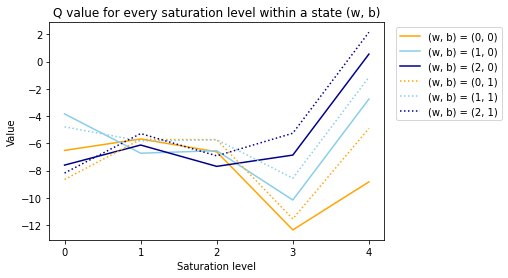

In [6]:
plot_df = pd.DataFrame(
    columns=env.P_bw.index, index=set(env.S) - set([min(env.S), max(env.S)])
)
for i in [(x,) + eval(y) for x in plot_df.index for y in plot_df.columns]:
    plot_df.loc[i[0], f"{i[1:]}"] = Q_values_2NN.loc[f"{i}"]

col = ["orange", "skyblue", "darkblue"] * 2
linestyle = ["-"] * 3 + ["dotted"] * 3
_ = plt.figure()
for (i, j) in enumerate(plot_df.columns):
    _ = plt.plot(
        plot_df[j], color=col[i], linestyle=linestyle[i], label="(w, b) = " + j
    )

_ = plt.ylabel("Value")
_ = plt.xlabel("Saturation level")
_ = plt.title("Q value for every saturation level within a state (w, b)")
_ = plt.xticks(plot_df.index)
_ = plt.legend(bbox_to_anchor=(1.02, 1))
_ = plt.show()

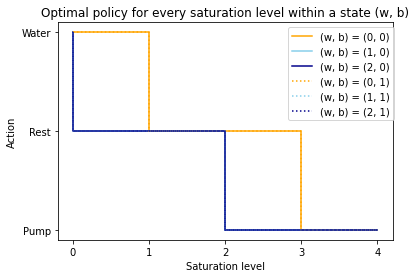

In [7]:
plot_df = pd.DataFrame(
    columns=env.P_bw.index, index=set(env.S) - set([min(env.S), max(env.S)])
)
for i in [(x,) + eval(y) for x in plot_df.index for y in plot_df.columns]:
    plot_df.loc[i[0], f"{i[1:]}"] = policy_2NN.loc[f"{i}"]

col = ["orange", "skyblue", "darkblue"] * 2
linestyle = ["-"] * 3 + ["dotted"] * 3
_ = plt.figure()
for (i, j) in enumerate(plot_df.columns):
    _ = plt.plot(
        plot_df[j],
        color=col[i],
        linestyle=(linestyle[i]),
        label="(w, b) = " + j,
        drawstyle="steps",
    )

_ = plt.ylabel("Action")
_ = plt.xlabel("Saturation level")
_ = plt.title("Optimal policy for every saturation level within a state (w, b)")
_ = plt.xticks(plot_df.index)
_ = plt.yticks(sorted(policy_2NN.unique()), env.A.values())
_ = plt.legend(bbox_to_anchor=(1.02, 1))
_ = plt.show()
